# Blondy's Soaring Prediction

Use herbie to build out a windgram, copying all the functionality of RASP by Andrew Berkley and Peter Spear

In [50]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from herbie.toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd
import matplotlib as mpl

recent = pd.Timestamp("now").floor("6h") #- pd.Timedelta("6H")
fxx = range(1,10)

In [51]:
# select locations to plot (lumby, revelstoke) by specifying their location in decimal degrees (E, N)
locations = {"coopers":{"longitude":-118.986010, "latitude":50.285681},
             "revelstoke":{"longitude":-118.092554,"latitude":50.959530},
            }


In [52]:
# pick out the variables we need for rasp and their respective levels
levels = ["ISBL_0550",           
          "ISBL_0600",           
          "ISBL_0650",
          "ISBL_0700",           
          "ISBL_0750",
          "ISBL_0800",
          "ISBL_0850",
          "ISBL_0875",
          "ISBL_0900",
          "ISBL_0925",
          "ISBL_0950",
          "ISBL_0970",
          "ISBL_0985",
          "ISBL_1015",
         ]

variables = {"TCDC":"Sfc",
             "HPBL":"Sfc",
             "PRATE":"Sfc",
             "PRES":"Sfc",
             "ORGPHY":"Sfc",
             "HGT":levels,
             "HGT":levels,
             "TMP":levels,
             "WIND":levels,
             "WDIR":levels,
             }

In [53]:
def get_variable(time, model, product, fxx, variable, level):
    """
    wrapper for herbie object, outputs an xarray
    """
    ds = Herbie(time,
                model=model,
                fxx=fxx,
                product=product,
                variable=variable,
                level=level,
                ).xarray()

    # if the variable name is unknown, assign it
    if "unknown" in ds:
        ds = ds.rename({"unknown":variable})
                
    return ds

In [54]:
def get_level(time, model, product, fxx, variable, level):
    """
    wrapper for get_variable, merges variables along isobaric levels
    """
    if len(level) > 1 and "ISBL" in level[0]: 
        ds = xr.concat([get_variable(time, model=model, product=product, fxx=fxx, variable=variable, level=lev) for lev in level], dim="isobaricInhPa")
    else:
        ds = get_variable(time, model=model, product=product, fxx=fxx, variable=variable, level=level)
        
    return ds

In [56]:
print(pd.Timestamp("now"))
ds = xr.concat([xr.merge([get_level(recent, model="hrdps", fxx=f, product="continental/2.5km", variable=v, level=variables[v]) for v in variables]) for f in fxx], dim="valid_time")
print(pd.Timestamp("now"))


2024-11-24 12:39:27.929741
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None
👨🏻‍🏭 Created directory: [/Users/andrew/data/hrdps/20241124]
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc2 ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F01 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc2 ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F02 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc2 ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc2 ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F04 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc2 ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F05 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc2 ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F06 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc2 ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F07 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc2 ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-24 12:00 UTC F08 ┊ GRIB2 @ msc ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1117: UserWarning: Will not remove GRIB file because Herbie will only remove subsetted files (not full files).
  warnings.warn(


OSError: [Errno 28] No space left on device

In [57]:
ds

<xarray.Dataset> Size: 878MB
Dimensions:              (valid_time: 9, y: 1290, x: 2540, isobaricInhPa: 2)
Coordinates:
    time                 datetime64[ns] 8B 2024-11-24T06:00:00
    step                 (valid_time) timedelta64[ns] 72B 01:00:00 ... 09:00:00
    surface              float64 8B 0.0
    latitude             (y, x) float64 26MB 39.63 39.63 39.64 ... 47.89 47.88
    longitude            (y, x) float64 26MB -133.6 -133.6 ... -40.73 -40.71
  * valid_time           (valid_time) datetime64[ns] 72B 2024-11-24T07:00:00 ...
    gribfile_projection  object 8B None
  * isobaricInhPa        (isobaricInhPa) float64 16B 550.0 600.0
Dimensions without coordinates: y, x
Data variables:
    TCDC                 (valid_time, y, x) float32 118MB 2.49 3.136 ... 86.88
    blh                  (valid_time, y, x) float32 118MB 1.497e+03 ... 1.283...
    prate                (valid_time, y, x) float32 118MB 0.0 0.0 ... 0.0 0.0
    sp                   (valid_time, y, x) float32 118MB 1.011e+05 ... 1.01e+05
    h                    (valid_time, y, x) float32 118MB -1.644 ... -1.644
    gh                   (valid_time, isobaricInhPa, y, x) float32 236MB 4.79...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    model:                   hrdps
    product:                 continental/2.5km
    description:             Canada's High Resolution Deterministic Predictio...
    remote_grib:             /Users/andrew/data/hrdps/20241124/20241124T06Z_M...
    local_grib:              /Users/andrew/data/hrdps/20241124/20241124T06Z_M...
    search:                  None

In [4]:
tstore = [] # timesteps
for fxx in np.arange(1,8): 
    vstore = [] # variable names
    for var in variables:
        print(var)
        lstore = [] # variable level (z)
        for level in variables[var]:
            __ds = Herbie(
                recent,
                model="hrdps",
                fxx=int(fxx),
                product="continental/2.5km",
                variable=var,
                level=level,
                ).xarray()

            # if the variable name is unknown, assign it
            if "unknown" in __ds:
                __ds = __ds.rename({"unknown":var})

            lstore.append(__ds)
        if len(variables[var]) > 1: # this only works for pressure levels at present. caution.
            __ds = xr.concat(lstore, dim="isobaricInhPa")
        vstore.append(__ds)  
    _ds = xr.merge(vstore)
    tstore.append(_ds)
ds = xr.concat(tstore, dim="valid_time") # merge timesteps

TCDC
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


HPBL
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None
PRATE


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None
PRES


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None
ORGPHY


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


HGT
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


TMP
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


WIND
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


WDIR
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F01 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


TCDC
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None
HPBL


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None
PRATE


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None
PRES


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None
ORGPHY


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None
HGT


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


TMP
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


WIND
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


WDIR
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F02 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


TCDC
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None
HPBL


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None
PRATE


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None
PRES


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None
ORGPHY


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None
HGT


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


TMP
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


WIND
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


WDIR
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F03 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


TCDC
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None
HPBL


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None
PRATE


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None
PRES


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None
ORGPHY


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None
HGT


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


TMP
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


WIND
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


WDIR
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F04 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


TCDC
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None
HPBL


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None
PRATE


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None
PRES


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None
ORGPHY


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None
HGT


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


TMP
✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


✅ Found ┊ model=hrdps ┊ product=continental/2.5km ┊ 2024-Nov-23 18:00 UTC F05 ┊ GRIB2 @ local ┊ IDX @ None


/opt/miniconda3/envs/herbie/lib/python3.13/site-packages/herbie/core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")

KeyboardInterrupt



In [60]:
ds["lr"] = ds.t.diff(dim="isobaricInhPa") / ds.gh.diff(dim="isobaricInhPa") # calculate lapse rate (degC/m)

AttributeError: 'Dataset' object has no attribute 't'

In [58]:
location="revelstoke"
# select the closest pixel to "revelstoke"
# HRDPS doesnt grid on lat/lon, so this becomes necessary
revelstoke = ds.sel((((ds.longitude - locations[location]["longitude"]) ** 2 
       + (ds.latitude - locations[location]["latitude"]) ** 2) ** 0.5).argmin(dim=["x", "y"]))
revelstoke = revelstoke.roll(valid_time=-8) #tz_localize('UTC').tz_convert('America/Vancouver') # make this less naive

AttributeError: 'Dataset' object has no attribute 'lr'

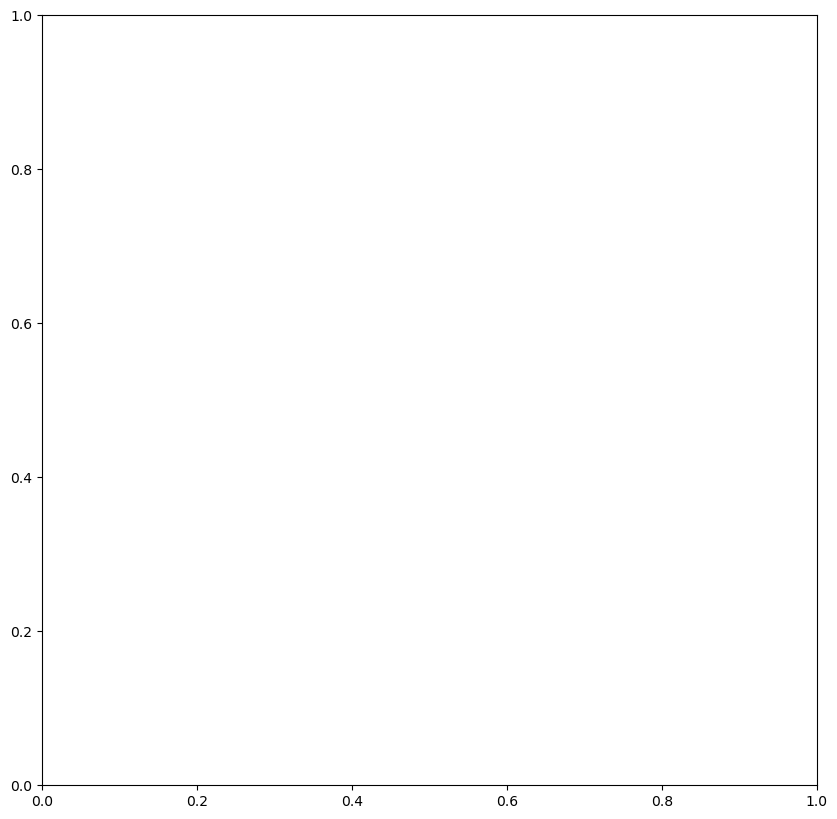

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))
lr_cmap = mpl.colors.ListedColormap(['#ff0000',
                                     '#ffa500',
                                     '#ff69b4',
                                     '#9370db',
                                     '#eee8aa',
                                     '#b0c4de',
                                     '#DCDCDC',
                                     '#808080',
                                    ])
lr_bounds = [-0.0098, -0.0085, -0.00725, -0.006, 0.000, 0.0025, 0.005]
lr_norm = mpl.colors.BoundaryNorm(lr_bounds, lr_cmap.N)
ax.contourf(revelstoke.valid_time, revelstoke.gh[0].values, revelstoke.lr.T, cmap=lr_cmap)
#ax.invert_yaxis()
#ax.set_yticks(ticks=revelstoke.isobaricInhPa.values, labels=revelstoke.gh[0].values)
